In [1]:
from google.colab import files

uploaded = files.upload()


Saving cleaned_reviews.csv to cleaned_reviews.csv


In [3]:
import pandas as pd

# Load cleaned reviews dataset
df = pd.read_csv("cleaned_reviews.csv")

# Preview the dataset
df.head()


,review,rating,date,bank,source
0,A great app. It's like carrying a bank in your...,4,2025-06-07,CBE,Google Play
1,More than garrantty bank EBC.,4,2025-06-07,CBE,Google Play
2,really am happy to this app it is Siple to use...,5,2025-06-07,CBE,Google Play
3,I liked this app. But the User interface is ve...,2,2025-06-07,CBE,Google Play
4,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,CBE,Google Play


In [4]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize analyzer
sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [5]:
# Function to assign sentiment
def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply to review column
df['sentiment'] = df['review'].astype(str).apply(get_sentiment)

# Check result
df[['review', 'sentiment']].head()


,review,sentiment
0,A great app. It's like carrying a bank in your...,positive
1,More than garrantty bank EBC.,neutral
2,really am happy to this app it is Siple to use...,positive
3,I liked this app. But the User interface is ve...,negative
4,"""Why don’t your ATMs support account-to-accoun...",positive


In [6]:
# Count by sentiment
df['sentiment'].value_counts()


,count
sentiment,
positive,787
neutral,404
negative,188


<ipython-input-7-25ba68b330ab>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='pastel')


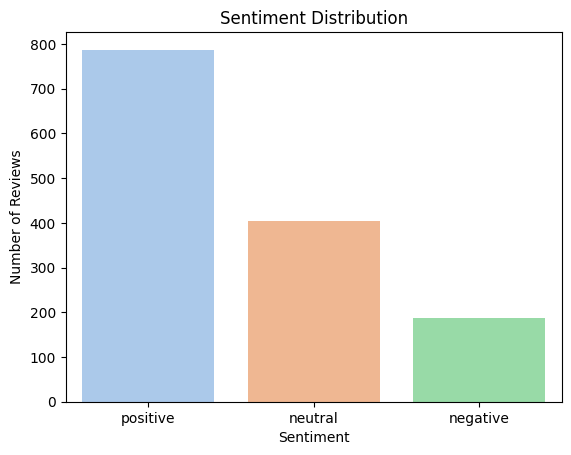

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment', palette='pastel')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


In [8]:
df.to_csv("bank_reviews_with_sentiment.csv", index=False)
